In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from pycaret.utils import version
version()
from pycaret.time_series import TSForecastingExperiment
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima.utils import nsdiffs, ndiffs
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

from statsmodels.tsa.seasonal import STL
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from keras.layers import LSTM, Dense

from tensorflow import keras # Import the main keras module (using TensorFlow backend)
from tensorflow.keras import callbacks  # Import just the callbacks submodule
import tensorflow as tf
import math
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import keras_tuner as kt  # ADD THIS LINE - Import Keras Tuner as kt
import yfinance as yf


In [5]:
df_USDT= yf.download(
tickers = ["USDT-USD"],
start = "2020-01-01",
end = "2025-01-01"
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df_USDT.head()

Price,Close,High,Low,Open,Volume
Ticker,USDT-USD,USDT-USD,USDT-USD,USDT-USD,USDT-USD
Date,,,,,
2020-01-01,0.999836,1.006873,0.994924,0.999571,21503143454
2020-01-02,1.001565,1.008451,0.986515,0.999788,24212314977
2020-01-03,1.004192,1.022286,0.988027,1.001183,32420287856
2020-01-04,1.007472,1.013633,0.999160,1.003510,21585629320
2020-01-05,1.006197,1.016161,1.001758,1.009921,24090142146


In [7]:
# Rename columns to remove multi-level indexing
df_USDT.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df_USDT.shape
df_USDT.info()
print('Null Values:',df_USDT.isnull().values.sum())
print(df_USDT.columns)
df_USDT.reset_index(inplace=True)
df_USDT['Date'] = pd.to_datetime(df_USDT['Date'], format='%Y-%m-%d')
df_USDT = df_USDT[['Date', 'Close']]
df_USDT.head()
# Set the Date column as the index
df_USDT.set_index('Date', inplace=True)
print(df_USDT.index)
df_USDT = df_USDT.asfreq('D')  # Resample to daily frequency
# Verify the frequency of the index
print(f"Frequency of the index: {df_USDT.index.freq}")


# View the last 10 data entries to identify datapoint columns
df_USDT.tail(10)
     

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1827 non-null   float64
 1   High    1827 non-null   float64
 2   Low     1827 non-null   float64
 3   Open    1827 non-null   float64
 4   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB
Null Values: 0
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=1827, freq=None)
Frequency of the ind

,Close
Date,
2024-12-22,0.999073
2024-12-23,0.998721
2024-12-24,0.999310
2024-12-25,0.999168
2024-12-26,0.998784
2024-12-27,0.998633
2024-12-28,0.998185
2024-12-29,0.998148
2024-12-30,0.998073


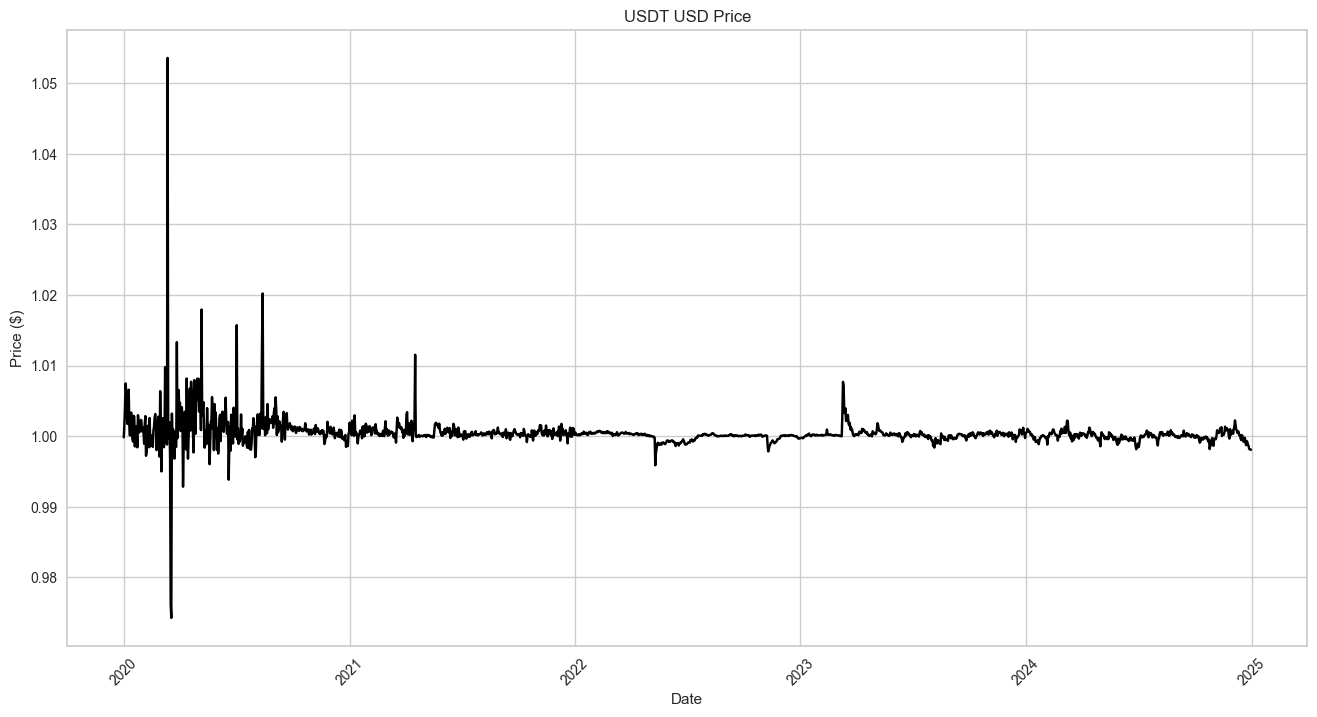

In [8]:
# Plot the close price
plt.figure(figsize=(16,8))
plt.plot(df_USDT['Close'], color='black')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.title('USDT USD Price')
plt.grid(True)
plt.show()

In [9]:
# Extract the 'Close' column from the data
close_prices = df_USDT['Close']

# Get the values from the 'Close' column as a NumPy array
values = close_prices.values

# Calculate the length of the training data by taking 60% of the total length of the 'values' array
training_data_len = int(len(values) * 0.6)
validation_data_len = int(len(values) * 0.2)
test_data_len = len(values) - training_data_len - validation_data_len

# Create a MinMaxScaler object and scale the values to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))


In [10]:
# Split the scaled data into training, validation, and test sets
train_data = scaled_data[0:training_data_len, :]
val_data = scaled_data[training_data_len - 60: training_data_len + validation_data_len, :]
test_data = scaled_data[training_data_len + validation_data_len - 60:, :]

# Initialize empty lists for the training, validation, and test inputs and outputs
x_train, y_train = [], []
x_val, y_val = [], []
x_test = []


In [11]:
# Loop through the training data and create input/output pairs
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the training inputs and outputs to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the training inputs to be 3D for use with an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [12]:
# Loop through the validation data and create input/output pairs
for i in range(60, len(val_data)):
    x_val.append(val_data[i - 60:i, 0])
    y_val.append(val_data[i, 0])

# Convert the validation inputs and outputs to NumPy arrays
x_val = np.array(x_val)
y_val = np.array(y_val)

# Reshape the validation inputs to be 3D for use with an LSTM model
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Loop through the test data and create input sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

In [13]:
# Convert the test inputs to a NumPy array and reshape to be 3D
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the test outputs as a NumPy array from the 'values' array
y_test = values[training_data_len + validation_data_len:]


In [14]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1036, 60, 1)
y_train shape: (1036,)
x_val shape: (365, 60, 1)
y_val shape: (365,)
x_test shape: (366, 60, 1)
y_test shape: (366,)


In [15]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=100, step=10)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model


In [16]:
# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='USDT_lstm_tuning'
)

In [17]:
# Perform hyperparameter tuning
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


Trial 5 Complete [00h 00m 39s]
val_loss: 9.277386319202681e-05

Best val_loss So Far: 7.13085488920721e-05
Total elapsed time: 00h 06m 01s


In [18]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,521 (1.89 MB)

 Trainable params: 494,521 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Evaluate the best model on the test set
predictions = best_model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('Root mean squared error:', rmse)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Root mean squared error: 0.0001350838304217396


In [20]:
# Evaluate LSTM Model Performance
rmse_lstm = np.sqrt(mean_squared_error(y_test, predictions))
mae_lstm = mean_absolute_error(y_test, predictions)
mape_lstm = mean_absolute_percentage_error(y_test, predictions)
r2_lstm = r2_score(y_test, predictions)

# Print Evaluation Metrics
print("\n--- LSTM Model Evaluation Metrics (Hold-out Set) ---")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lstm:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm:.4%}")
print(f"R-squared (R²): {r2_lstm:.4f}")


--- LSTM Model Evaluation Metrics (Hold-out Set) ---
Root Mean Squared Error (RMSE): 0.0005
Mean Absolute Error (MAE): 0.0004
Mean Absolute Percentage Error (MAPE): 0.0398%
R-squared (R²): 0.2861


In [21]:
# Print Metrics for Comparison Table in Thesis
print("\n--- LSTM Hold-out Metrics (for Thesis Table) ---")
print(f"LSTM Hold-out RMSE:  {rmse_lstm:.4f}")
print(f"LSTM Hold-out MAE:   {mae_lstm:.4f}")
print(f"LSTM Hold-out MAPE:  {mape_lstm:.4%}")
print(f"LSTM Hold-out R²:    {r2_lstm:.4f}")


--- LSTM Hold-out Metrics (for Thesis Table) ---
LSTM Hold-out RMSE:  0.0005
LSTM Hold-out MAE:   0.0004
LSTM Hold-out MAPE:  0.0398%
LSTM Hold-out R²:    0.2861


In [22]:
# Prepare data for plotting
df_USDT = df_USDT.filter(['Close'])
train = df_USDT[:training_data_len]
validation = df_USDT[training_data_len:training_data_len + validation_data_len]
test = df_USDT[training_data_len + validation_data_len:]
test['Predictions'] = predictions
train.reset_index(inplace=True)
validation.reset_index(inplace=True)
test.reset_index(inplace=True)

In [23]:
# Plot the results
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price (train)'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price (validation)'))
fig.add_trace(go.Scatter(x=test.Date, y=test.Close, mode='lines', name='Actual Price (test)'))
fig.add_trace(go.Scatter(x=test.Date, y=test.Predictions, mode='lines', name='Predicted price'))
fig.update_layout(
    title="Time series Forecasting using LSTM for USDT (USDT) Price Prediction",
    xaxis_title="Date-Time",
    yaxis_title="Values",
    legend_title="Legend",
)
fig.show()